In [7]:
import torch
from torchvision import datasets
from torchvision.transforms import v2


batch_size = 128
transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Lambda(lambda x: x.view(-1) - 0.5),
])

# Download and load the training data
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform=transform,
)
# Download and load the test data
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform,
)

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

In [8]:
from datetime import datetime
from vae import VAE  # Assuming the VAE class is defined in vae.py
import torch
from torch.utils.tensorboard import SummaryWriter

learning_rate = 1e-3
weight_decay = 1e-2
num_epochs = 50
latent_dim = 2
hidden_dim = 512

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE(input_dim=784, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
writer = SummaryWriter(f'runs/mnist/vae_{datetime.now().strftime("%Y%m%d-%H%M%S")}')



In [9]:
#print model layers for name, param in model.named_parameters():
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Layer: {name}, Size: {param.size()}, Values: {param[:2]}")


Layer: encoder.0.weight, Size: torch.Size([512, 784]), Values: tensor([[-0.0299, -0.0323, -0.0173,  ...,  0.0179,  0.0191,  0.0145],
        [ 0.0202, -0.0034,  0.0162,  ..., -0.0279,  0.0026,  0.0288]],
       grad_fn=<SliceBackward0>)
Layer: encoder.0.bias, Size: torch.Size([512]), Values: tensor([-0.0050,  0.0097], grad_fn=<SliceBackward0>)
Layer: encoder.2.weight, Size: torch.Size([256, 512]), Values: tensor([[ 0.0309,  0.0119,  0.0045,  ...,  0.0034, -0.0318,  0.0316],
        [ 0.0050, -0.0329, -0.0121,  ..., -0.0403,  0.0071,  0.0046]],
       grad_fn=<SliceBackward0>)
Layer: encoder.2.bias, Size: torch.Size([256]), Values: tensor([-0.0321, -0.0298], grad_fn=<SliceBackward0>)
Layer: encoder.4.weight, Size: torch.Size([128, 256]), Values: tensor([[ 0.0601,  0.0594, -0.0165,  0.0570, -0.0478, -0.0618,  0.0017, -0.0584,
         -0.0053,  0.0273, -0.0157,  0.0515,  0.0225,  0.0543,  0.0477,  0.0082,
         -0.0610,  0.0212, -0.0231,  0.0139,  0.0197, -0.0232, -0.0036,  0.0133,
  

In [10]:
def train(model, dataloader, optimizer, prev_updates, writer=None):
    """
    Trains the model on the given data.
    
    Args:
        model (nn.Module): The model to train.
        dataloader (torch.utils.data.DataLoader): The data loader.
        loss_fn: The loss function.
        optimizer: The optimizer.
    """
    model.train()  # Set the model to training mode
    
    for batch_idx, (data, target) in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        
        optimizer.zero_grad()  # Zero the gradients
        
        output = model(data)  # Forward pass
        loss = output.loss
        
        loss.backward()
        
        if n_upd % 100 == 0:
            # Calculate and log gradient norms
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)
        
            print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon: {output.loss_recon.item():.4f}, KL: {output.loss_kl.item():.4f}) Grad: {total_norm:.4f}')

            if writer is not None:
                global_step = n_upd
                writer.add_scalar('Loss/Train', loss.item(), global_step)
                writer.add_scalar('Loss/Train/BCE', output.loss_recon.item(), global_step)
                writer.add_scalar('Loss/Train/KLD', output.loss_kl.item(), global_step)
                writer.add_scalar('GradNorm/Train', total_norm, global_step)
            
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        
        optimizer.step()  # Update the model parameters
        
    return prev_updates + len(dataloader)

In [11]:
def test(model, dataloader, cur_step, writer=None):
    """
    Tests the model on the given data.
    
    Args:
        model (nn.Module): The model to test.
        dataloader (torch.utils.data.DataLoader): The data loader.
        cur_step (int): The current step.
        writer: The TensorBoard writer.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0
    
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            data = data.view(data.size(0), -1)  # Flatten the data
            
            output = model(data, compute_loss=True)  # Forward pass
            
            test_loss += output.loss.item()
            test_recon_loss += output.loss_recon.item()
            test_kl_loss += output.loss_kl.item()
            
    test_loss /= len(dataloader)
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    print(f'====> Test set loss: {test_loss:.4f} (BCE: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f})')
    
    if writer is not None:
        writer.add_scalar('Loss/Test', test_loss, global_step=cur_step)
        writer.add_scalar('Loss/Test/BCE', output.loss_recon.item(), global_step=cur_step)
        writer.add_scalar('Loss/Test/KLD', output.loss_kl.item(), global_step=cur_step)
        
        # Log reconstructions
        writer.add_images('Test/Reconstructions', output.x_recon.view(-1, 1, 28, 28), global_step=cur_step)
        writer.add_images('Test/Originals', data.view(-1, 1, 28, 28), global_step=cur_step)
        
        # Log random samples from the latent space
        z = torch.randn(16, latent_dim).to(device)
        samples = model.decode(z)
        writer.add_images('Test/Samples', samples.view(-1, 1, 28, 28), global_step=cur_step)

In [12]:
from tqdm import tqdm

prev_updates = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
    test(model, test_loader, prev_updates, writer=writer)

Epoch 1/50


  0%|          | 1/469 [00:00<02:22,  3.28it/s]

Step 0 (N samples: 0), Loss: 544.0703 (Recon: 543.8493, KL: 0.2210) Grad: 13.2723


 22%|██▏       | 102/469 [00:05<00:17, 21.25it/s]

Step 100 (N samples: 12,800), Loss: 188.1693 (Recon: 186.1405, KL: 2.0288) Grad: 17.7695


 43%|████▎     | 204/469 [00:10<00:11, 23.19it/s]

Step 200 (N samples: 25,600), Loss: 190.6293 (Recon: 188.3138, KL: 2.3155) Grad: 97.5299


 65%|██████▍   | 303/469 [00:14<00:07, 22.54it/s]

Step 300 (N samples: 38,400), Loss: 186.1000 (Recon: 183.6297, KL: 2.4703) Grad: 49.1283


 86%|████████▋ | 405/469 [00:18<00:02, 22.53it/s]

Step 400 (N samples: 51,200), Loss: 171.9291 (Recon: 167.6547, KL: 4.2744) Grad: 16.8693


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.98it/s]


====> Test set loss: 169.1524 (BCE: 164.8711, KLD: 4.2813)
Epoch 2/50


  7%|▋         | 35/469 [00:01<00:16, 26.16it/s]

Step 500 (N samples: 64,000), Loss: 174.3324 (Recon: 169.9910, KL: 4.3414) Grad: 48.3432


 29%|██▊       | 134/469 [00:05<00:13, 24.82it/s]

Step 600 (N samples: 76,800), Loss: 162.1913 (Recon: 157.2045, KL: 4.9868) Grad: 47.5076


 50%|█████     | 236/469 [00:09<00:09, 25.06it/s]

Step 700 (N samples: 89,600), Loss: 164.5635 (Recon: 159.6764, KL: 4.8870) Grad: 68.2423


 71%|███████▏  | 335/469 [00:13<00:05, 25.53it/s]

Step 800 (N samples: 102,400), Loss: 163.7051 (Recon: 158.7215, KL: 4.9836) Grad: 82.8316


 93%|█████████▎| 434/469 [00:16<00:01, 24.67it/s]

Step 900 (N samples: 115,200), Loss: 156.0993 (Recon: 150.7414, KL: 5.3579) Grad: 35.3987


Testing: 100%|██████████| 79/79 [00:02<00:00, 35.94it/s]


====> Test set loss: 156.6554 (BCE: 151.4241, KLD: 5.2313)
Epoch 3/50


 14%|█▍        | 67/469 [00:02<00:15, 25.72it/s]

Step 1,000 (N samples: 128,000), Loss: 151.4787 (Recon: 145.9738, KL: 5.5049) Grad: 62.8365


 35%|███▌      | 166/469 [00:06<00:12, 24.96it/s]

Step 1,100 (N samples: 140,800), Loss: 150.8240 (Recon: 145.4798, KL: 5.3442) Grad: 44.3824


 57%|█████▋    | 265/469 [00:10<00:08, 24.28it/s]

Step 1,200 (N samples: 153,600), Loss: 156.7871 (Recon: 151.0434, KL: 5.7438) Grad: 94.9250


 78%|███████▊  | 367/469 [00:14<00:04, 24.78it/s]

Step 1,300 (N samples: 166,400), Loss: 150.4247 (Recon: 144.7966, KL: 5.6281) Grad: 123.5643


 99%|█████████▉| 466/469 [00:18<00:00, 23.16it/s]

Step 1,400 (N samples: 179,200), Loss: 157.0454 (Recon: 151.6444, KL: 5.4011) Grad: 64.1934


Testing: 100%|██████████| 79/79 [00:02<00:00, 35.91it/s]


====> Test set loss: 151.0810 (BCE: 145.4873, KLD: 5.5937)
Epoch 4/50


 21%|██        | 98/469 [00:04<00:14, 25.51it/s]

Step 1,500 (N samples: 192,000), Loss: 142.7200 (Recon: 136.8515, KL: 5.8685) Grad: 103.7426


 42%|████▏     | 197/469 [00:07<00:10, 25.95it/s]

Step 1,600 (N samples: 204,800), Loss: 152.8157 (Recon: 147.0414, KL: 5.7744) Grad: 94.7853


 63%|██████▎   | 296/469 [00:11<00:06, 25.45it/s]

Step 1,700 (N samples: 217,600), Loss: 153.3988 (Recon: 147.5943, KL: 5.8044) Grad: 134.1810


 85%|████████▍ | 398/469 [00:15<00:02, 25.30it/s]

Step 1,800 (N samples: 230,400), Loss: 143.8904 (Recon: 137.7552, KL: 6.1352) Grad: 91.3980


Testing: 100%|██████████| 79/79 [00:02<00:00, 35.42it/s]


====> Test set loss: 147.9254 (BCE: 142.0604, KLD: 5.8650)
Epoch 5/50


  6%|▌         | 26/469 [00:01<00:27, 15.84it/s]

Step 1,900 (N samples: 243,200), Loss: 144.6558 (Recon: 138.5691, KL: 6.0867) Grad: 62.9526


 27%|██▋       | 128/469 [00:05<00:15, 22.28it/s]

Step 2,000 (N samples: 256,000), Loss: 150.7715 (Recon: 144.6859, KL: 6.0856) Grad: 129.6053


 48%|████▊     | 227/469 [00:09<00:09, 25.63it/s]

Step 2,100 (N samples: 268,800), Loss: 144.7066 (Recon: 138.6527, KL: 6.0539) Grad: 77.3060


 70%|███████   | 329/469 [00:13<00:05, 26.35it/s]

Step 2,200 (N samples: 281,600), Loss: 144.4471 (Recon: 138.5556, KL: 5.8915) Grad: 126.4849


 91%|█████████▏| 428/469 [00:17<00:01, 21.02it/s]

Step 2,300 (N samples: 294,400), Loss: 147.1628 (Recon: 141.1108, KL: 6.0519) Grad: 135.8313


Testing: 100%|██████████| 79/79 [00:02<00:00, 36.02it/s]


====> Test set loss: 146.7592 (BCE: 140.5773, KLD: 6.1819)
Epoch 6/50


 12%|█▏        | 58/469 [00:02<00:17, 22.90it/s]

Step 2,400 (N samples: 307,200), Loss: 146.0397 (Recon: 139.8992, KL: 6.1406) Grad: 133.3989


 34%|███▍      | 160/469 [00:06<00:12, 25.54it/s]

Step 2,500 (N samples: 320,000), Loss: 151.0361 (Recon: 144.9254, KL: 6.1107) Grad: 167.4738


 55%|█████▍    | 256/469 [00:09<00:08, 26.58it/s]

Step 2,600 (N samples: 332,800), Loss: 150.2057 (Recon: 144.1994, KL: 6.0063) Grad: 73.6676


 76%|███████▋  | 358/469 [00:14<00:04, 23.77it/s]

Step 2,700 (N samples: 345,600), Loss: 154.4745 (Recon: 148.3030, KL: 6.1715) Grad: 113.0813


 98%|█████████▊| 460/469 [00:18<00:00, 24.86it/s]

Step 2,800 (N samples: 358,400), Loss: 145.9136 (Recon: 139.7490, KL: 6.1646) Grad: 79.8598


Testing: 100%|██████████| 79/79 [00:02<00:00, 34.84it/s]


====> Test set loss: 146.2358 (BCE: 139.8716, KLD: 6.3642)
Epoch 7/50


 19%|█▉        | 89/469 [00:03<00:14, 25.78it/s]

Step 2,900 (N samples: 371,200), Loss: 146.3535 (Recon: 140.0695, KL: 6.2840) Grad: 82.7676


 40%|████      | 188/469 [00:07<00:11, 24.73it/s]

Step 3,000 (N samples: 384,000), Loss: 143.8754 (Recon: 137.4552, KL: 6.4202) Grad: 84.5170


 62%|██████▏   | 290/469 [00:11<00:07, 23.48it/s]

Step 3,100 (N samples: 396,800), Loss: 138.2552 (Recon: 131.8156, KL: 6.4396) Grad: 70.2826


 83%|████████▎ | 389/469 [00:15<00:03, 26.13it/s]

Step 3,200 (N samples: 409,600), Loss: 143.4537 (Recon: 137.2062, KL: 6.2474) Grad: 121.8825


Testing: 100%|██████████| 79/79 [00:02<00:00, 36.05it/s]


====> Test set loss: 143.3417 (BCE: 137.0433, KLD: 6.2984)
Epoch 8/50


  4%|▍         | 21/469 [00:00<00:19, 22.51it/s]

Step 3,300 (N samples: 422,400), Loss: 152.6175 (Recon: 146.1441, KL: 6.4734) Grad: 46.7654


 26%|██▌       | 120/469 [00:04<00:13, 26.12it/s]

Step 3,400 (N samples: 435,200), Loss: 151.8535 (Recon: 145.9869, KL: 5.8666) Grad: 89.7400


 47%|████▋     | 222/469 [00:08<00:09, 25.87it/s]

Step 3,500 (N samples: 448,000), Loss: 144.0684 (Recon: 137.8734, KL: 6.1950) Grad: 79.8683


 68%|██████▊   | 318/469 [00:12<00:05, 26.72it/s]

Step 3,600 (N samples: 460,800), Loss: 139.6602 (Recon: 133.3000, KL: 6.3601) Grad: 161.7350


 90%|████████▉ | 420/469 [00:16<00:02, 23.48it/s]

Step 3,700 (N samples: 473,600), Loss: 146.9440 (Recon: 140.6455, KL: 6.2986) Grad: 93.7366


Testing: 100%|██████████| 79/79 [00:02<00:00, 34.79it/s]


====> Test set loss: 143.5138 (BCE: 137.1200, KLD: 6.3938)
Epoch 9/50


 11%|█         | 51/469 [00:01<00:16, 26.11it/s]

Step 3,800 (N samples: 486,400), Loss: 140.2858 (Recon: 133.7924, KL: 6.4933) Grad: 131.6726


 33%|███▎      | 153/469 [00:05<00:12, 26.12it/s]

Step 3,900 (N samples: 499,200), Loss: 150.1152 (Recon: 143.8455, KL: 6.2697) Grad: 86.3304


 54%|█████▎    | 252/469 [00:09<00:08, 25.63it/s]

Step 4,000 (N samples: 512,000), Loss: 144.8723 (Recon: 138.5411, KL: 6.3313) Grad: 91.7616


 75%|███████▍  | 351/469 [00:13<00:04, 26.13it/s]

Step 4,100 (N samples: 524,800), Loss: 140.8723 (Recon: 134.4338, KL: 6.4385) Grad: 124.6393


 97%|█████████▋| 453/469 [00:17<00:00, 25.79it/s]

Step 4,200 (N samples: 537,600), Loss: 140.6498 (Recon: 134.0606, KL: 6.5892) Grad: 124.3749


Testing: 100%|██████████| 79/79 [00:02<00:00, 36.07it/s]


====> Test set loss: 146.4415 (BCE: 140.0065, KLD: 6.4350)
Epoch 10/50


 18%|█▊        | 83/469 [00:03<00:16, 23.79it/s]

Step 4,300 (N samples: 550,400), Loss: 146.8224 (Recon: 140.4929, KL: 6.3295) Grad: 110.0715


 39%|███▉      | 182/469 [00:07<00:11, 24.63it/s]

Step 4,400 (N samples: 563,200), Loss: 139.0201 (Recon: 132.5790, KL: 6.4411) Grad: 70.5504


 61%|██████    | 284/469 [00:11<00:07, 25.03it/s]

Step 4,500 (N samples: 576,000), Loss: 133.0867 (Recon: 126.4345, KL: 6.6522) Grad: 71.1279


 82%|████████▏ | 383/469 [00:15<00:03, 25.58it/s]

Step 4,600 (N samples: 588,800), Loss: 148.2181 (Recon: 141.7591, KL: 6.4589) Grad: 114.2293


Testing: 100%|██████████| 79/79 [00:02<00:00, 36.10it/s]


====> Test set loss: 142.9681 (BCE: 136.5542, KLD: 6.4140)
Epoch 11/50


  3%|▎         | 13/469 [00:00<00:19, 23.96it/s]

Step 4,700 (N samples: 601,600), Loss: 149.0800 (Recon: 142.9234, KL: 6.1566) Grad: 116.4259


 25%|██▍       | 115/469 [00:04<00:14, 25.24it/s]

Step 4,800 (N samples: 614,400), Loss: 146.2809 (Recon: 139.8592, KL: 6.4218) Grad: 78.7953


 46%|████▌     | 214/469 [00:08<00:10, 23.96it/s]

Step 4,900 (N samples: 627,200), Loss: 143.5255 (Recon: 136.8266, KL: 6.6989) Grad: 157.9488


 67%|██████▋   | 313/469 [00:12<00:06, 24.54it/s]

Step 5,000 (N samples: 640,000), Loss: 141.9079 (Recon: 135.5014, KL: 6.4065) Grad: 133.0397


 88%|████████▊ | 415/469 [00:16<00:02, 25.58it/s]

Step 5,100 (N samples: 652,800), Loss: 137.0322 (Recon: 130.2865, KL: 6.7456) Grad: 115.2270


Testing: 100%|██████████| 79/79 [00:02<00:00, 35.99it/s]


====> Test set loss: 143.2875 (BCE: 136.7220, KLD: 6.5655)
Epoch 12/50


 10%|▉         | 45/469 [00:01<00:16, 26.11it/s]

Step 5,200 (N samples: 665,600), Loss: 137.3233 (Recon: 130.6273, KL: 6.6960) Grad: 104.4646


 31%|███       | 144/469 [00:05<00:13, 24.56it/s]

Step 5,300 (N samples: 678,400), Loss: 133.8278 (Recon: 127.3788, KL: 6.4490) Grad: 100.7735


 52%|█████▏    | 246/469 [00:09<00:08, 25.26it/s]

Step 5,400 (N samples: 691,200), Loss: 145.7484 (Recon: 139.1655, KL: 6.5829) Grad: 187.1482


 74%|███████▎  | 345/469 [00:13<00:05, 22.23it/s]

Step 5,500 (N samples: 704,000), Loss: 141.7342 (Recon: 135.0995, KL: 6.6348) Grad: 196.3009


 95%|█████████▍| 444/469 [00:17<00:00, 25.09it/s]

Step 5,600 (N samples: 716,800), Loss: 139.9062 (Recon: 133.2694, KL: 6.6368) Grad: 128.6862


Testing: 100%|██████████| 79/79 [00:02<00:00, 35.83it/s]


====> Test set loss: 142.6813 (BCE: 136.1531, KLD: 6.5282)
Epoch 13/50


 16%|█▌        | 75/469 [00:02<00:16, 24.19it/s]

Step 5,700 (N samples: 729,600), Loss: 134.4192 (Recon: 127.7693, KL: 6.6499) Grad: 105.5294


 38%|███▊      | 177/469 [00:06<00:11, 25.43it/s]

Step 5,800 (N samples: 742,400), Loss: 134.8240 (Recon: 128.3324, KL: 6.4916) Grad: 96.5660


 59%|█████▉    | 276/469 [00:10<00:08, 24.00it/s]

Step 5,900 (N samples: 755,200), Loss: 144.1368 (Recon: 137.6710, KL: 6.4658) Grad: 74.0333


 80%|███████▉  | 375/469 [00:14<00:03, 25.55it/s]

Step 6,000 (N samples: 768,000), Loss: 138.5659 (Recon: 132.1348, KL: 6.4312) Grad: 157.8600


Testing: 100%|██████████| 79/79 [00:02<00:00, 34.13it/s]


====> Test set loss: 140.6292 (BCE: 134.0462, KLD: 6.5830)
Epoch 14/50


  1%|▏         | 6/469 [00:00<00:27, 16.58it/s]

Step 6,100 (N samples: 780,800), Loss: 141.9112 (Recon: 135.4701, KL: 6.4411) Grad: 134.4368


 23%|██▎       | 108/469 [00:04<00:14, 25.17it/s]

Step 6,200 (N samples: 793,600), Loss: 141.5012 (Recon: 134.6854, KL: 6.8158) Grad: 97.0273


 44%|████▍     | 207/469 [00:07<00:10, 25.42it/s]

Step 6,300 (N samples: 806,400), Loss: 144.2862 (Recon: 137.7316, KL: 6.5546) Grad: 80.9882


 65%|██████▌   | 306/469 [00:11<00:06, 25.66it/s]

Step 6,400 (N samples: 819,200), Loss: 140.5887 (Recon: 134.0017, KL: 6.5870) Grad: 114.9734


 87%|████████▋ | 408/469 [00:15<00:02, 24.40it/s]

Step 6,500 (N samples: 832,000), Loss: 141.0931 (Recon: 134.5034, KL: 6.5897) Grad: 95.7389


Testing: 100%|██████████| 79/79 [00:02<00:00, 36.18it/s]


====> Test set loss: 141.0477 (BCE: 134.4454, KLD: 6.6023)
Epoch 15/50


  8%|▊         | 36/469 [00:01<00:19, 22.77it/s]

Step 6,600 (N samples: 844,800), Loss: 148.3437 (Recon: 141.6321, KL: 6.7117) Grad: 274.3664


 29%|██▉       | 138/469 [00:05<00:12, 25.60it/s]

Step 6,700 (N samples: 857,600), Loss: 134.4437 (Recon: 127.6900, KL: 6.7537) Grad: 150.4456


 51%|█████     | 237/469 [00:09<00:10, 22.69it/s]

Step 6,800 (N samples: 870,400), Loss: 137.3453 (Recon: 130.7096, KL: 6.6357) Grad: 101.9829


 72%|███████▏  | 339/469 [00:13<00:05, 25.56it/s]

Step 6,900 (N samples: 883,200), Loss: 137.1303 (Recon: 130.5147, KL: 6.6156) Grad: 157.8934


 93%|█████████▎| 438/469 [00:17<00:01, 23.51it/s]

Step 7,000 (N samples: 896,000), Loss: 141.9696 (Recon: 135.1555, KL: 6.8140) Grad: 64.9077


Testing: 100%|██████████| 79/79 [00:02<00:00, 36.25it/s]


====> Test set loss: 138.9389 (BCE: 132.3288, KLD: 6.6101)
Epoch 16/50


 14%|█▍        | 68/469 [00:02<00:16, 23.99it/s]

Step 7,100 (N samples: 908,800), Loss: 141.3963 (Recon: 134.6402, KL: 6.7562) Grad: 115.9914


 36%|███▌      | 170/469 [00:06<00:11, 26.55it/s]

Step 7,200 (N samples: 921,600), Loss: 139.1317 (Recon: 132.5723, KL: 6.5594) Grad: 75.6606


 57%|█████▋    | 269/469 [00:10<00:08, 22.88it/s]

Step 7,300 (N samples: 934,400), Loss: 134.0916 (Recon: 127.4990, KL: 6.5927) Grad: 158.2079


 78%|███████▊  | 366/469 [00:16<00:12,  8.27it/s]

Step 7,400 (N samples: 947,200), Loss: 146.9406 (Recon: 140.2540, KL: 6.6866) Grad: 97.3771


100%|██████████| 469/469 [00:21<00:00, 21.54it/s]


Step 7,500 (N samples: 960,000), Loss: 136.4091 (Recon: 129.7675, KL: 6.6417) Grad: 120.0334


Testing: 100%|██████████| 79/79 [00:02<00:00, 35.75it/s]


====> Test set loss: 140.6108 (BCE: 133.9574, KLD: 6.6534)
Epoch 17/50


 22%|██▏       | 101/469 [00:03<00:14, 26.03it/s]

Step 7,600 (N samples: 972,800), Loss: 142.9405 (Recon: 136.1025, KL: 6.8379) Grad: 116.7031


 43%|████▎     | 200/469 [00:07<00:10, 25.28it/s]

Step 7,700 (N samples: 985,600), Loss: 143.4335 (Recon: 136.5777, KL: 6.8558) Grad: 133.7594


 64%|██████▍   | 299/469 [00:11<00:06, 25.21it/s]

Step 7,800 (N samples: 998,400), Loss: 142.1494 (Recon: 135.6688, KL: 6.4806) Grad: 105.8692


 86%|████████▌ | 401/469 [00:15<00:02, 25.37it/s]

Step 7,900 (N samples: 1,011,200), Loss: 139.7775 (Recon: 133.2386, KL: 6.5389) Grad: 204.1668


Testing: 100%|██████████| 79/79 [00:02<00:00, 34.14it/s]


====> Test set loss: 140.5794 (BCE: 133.9076, KLD: 6.6718)
Epoch 18/50


  6%|▌         | 29/469 [00:01<00:18, 23.25it/s]

Step 8,000 (N samples: 1,024,000), Loss: 135.5685 (Recon: 128.8158, KL: 6.7527) Grad: 98.7905


 28%|██▊       | 131/469 [00:05<00:14, 23.12it/s]

Step 8,100 (N samples: 1,036,800), Loss: 142.1416 (Recon: 135.3871, KL: 6.7546) Grad: 143.2543


 49%|████▉     | 232/469 [00:09<00:14, 16.48it/s]

Step 8,200 (N samples: 1,049,600), Loss: 143.9543 (Recon: 137.2290, KL: 6.7253) Grad: 86.4409


 70%|███████   | 330/469 [00:13<00:05, 26.00it/s]

Step 8,300 (N samples: 1,062,400), Loss: 140.8964 (Recon: 134.3022, KL: 6.5942) Grad: 169.0808


 91%|█████████▏| 429/469 [00:17<00:01, 21.44it/s]

Step 8,400 (N samples: 1,075,200), Loss: 136.0727 (Recon: 129.4431, KL: 6.6296) Grad: 93.7956


Testing: 100%|██████████| 79/79 [00:02<00:00, 35.19it/s]


====> Test set loss: 139.0187 (BCE: 132.2313, KLD: 6.7873)
Epoch 19/50


 13%|█▎        | 61/469 [00:02<00:16, 25.30it/s]

Step 8,500 (N samples: 1,088,000), Loss: 134.7419 (Recon: 127.9332, KL: 6.8087) Grad: 141.4585


 35%|███▍      | 163/469 [00:06<00:12, 25.41it/s]

Step 8,600 (N samples: 1,100,800), Loss: 140.4377 (Recon: 133.6479, KL: 6.7897) Grad: 142.2081


 55%|█████▌    | 259/469 [00:09<00:07, 26.92it/s]

Step 8,700 (N samples: 1,113,600), Loss: 136.6217 (Recon: 129.7286, KL: 6.8931) Grad: 130.1408


 77%|███████▋  | 361/469 [00:14<00:04, 24.48it/s]

Step 8,800 (N samples: 1,126,400), Loss: 145.2831 (Recon: 138.4855, KL: 6.7976) Grad: 82.7841


 99%|█████████▊| 463/469 [00:18<00:00, 25.65it/s]

Step 8,900 (N samples: 1,139,200), Loss: 136.1117 (Recon: 129.5494, KL: 6.5623) Grad: 137.6159


Testing: 100%|██████████| 79/79 [00:02<00:00, 35.73it/s]


====> Test set loss: 140.5316 (BCE: 133.7952, KLD: 6.7364)
Epoch 20/50


 20%|█▉        | 92/469 [00:03<00:15, 23.72it/s]

Step 9,000 (N samples: 1,152,000), Loss: 144.8233 (Recon: 138.0485, KL: 6.7748) Grad: 188.9219


 41%|████▏     | 194/469 [00:07<00:10, 25.70it/s]

Step 9,100 (N samples: 1,164,800), Loss: 145.1457 (Recon: 138.4224, KL: 6.7233) Grad: 86.9660


 62%|██████▏   | 293/469 [00:11<00:07, 23.03it/s]

Step 9,200 (N samples: 1,177,600), Loss: 146.4751 (Recon: 139.8548, KL: 6.6204) Grad: 146.6422


 84%|████████▎ | 392/469 [00:15<00:03, 23.23it/s]

Step 9,300 (N samples: 1,190,400), Loss: 135.1496 (Recon: 128.3002, KL: 6.8494) Grad: 189.6627


Testing: 100%|██████████| 79/79 [00:02<00:00, 34.99it/s]


====> Test set loss: 139.6103 (BCE: 132.8849, KLD: 6.7254)
Epoch 21/50


  5%|▌         | 25/469 [00:01<00:18, 23.44it/s]

Step 9,400 (N samples: 1,203,200), Loss: 142.8006 (Recon: 135.9715, KL: 6.8291) Grad: 144.8264


 26%|██▋       | 124/469 [00:05<00:14, 23.40it/s]

Step 9,500 (N samples: 1,216,000), Loss: 143.9670 (Recon: 137.1292, KL: 6.8378) Grad: 146.2022


 48%|████▊     | 223/469 [00:09<00:09, 25.60it/s]

Step 9,600 (N samples: 1,228,800), Loss: 135.2053 (Recon: 128.3565, KL: 6.8488) Grad: 108.0604


 69%|██████▉   | 325/469 [00:12<00:06, 23.93it/s]

Step 9,700 (N samples: 1,241,600), Loss: 140.5698 (Recon: 133.8331, KL: 6.7367) Grad: 141.1644


 90%|█████████ | 424/469 [00:16<00:01, 25.96it/s]

Step 9,800 (N samples: 1,254,400), Loss: 139.6613 (Recon: 132.9476, KL: 6.7137) Grad: 136.7920


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.85it/s]


====> Test set loss: 140.0221 (BCE: 133.2466, KLD: 6.7754)
Epoch 22/50


 12%|█▏        | 56/469 [00:02<00:16, 25.57it/s]

Step 9,900 (N samples: 1,267,200), Loss: 134.9064 (Recon: 128.2094, KL: 6.6970) Grad: 175.9861


 33%|███▎      | 155/469 [00:06<00:12, 24.27it/s]

Step 10,000 (N samples: 1,280,000), Loss: 143.9692 (Recon: 136.9813, KL: 6.9879) Grad: 186.9576


 54%|█████▍    | 254/469 [00:10<00:08, 24.91it/s]

Step 10,100 (N samples: 1,292,800), Loss: 139.1149 (Recon: 132.3065, KL: 6.8084) Grad: 155.9647


 76%|███████▌  | 356/469 [00:14<00:04, 26.17it/s]

Step 10,200 (N samples: 1,305,600), Loss: 132.1602 (Recon: 125.3211, KL: 6.8391) Grad: 146.3449


 97%|█████████▋| 455/469 [00:17<00:00, 25.47it/s]

Step 10,300 (N samples: 1,318,400), Loss: 144.0410 (Recon: 137.1829, KL: 6.8581) Grad: 150.7311


Testing: 100%|██████████| 79/79 [00:02<00:00, 35.30it/s]


====> Test set loss: 140.0734 (BCE: 133.2498, KLD: 6.8236)
Epoch 23/50


 18%|█▊        | 86/469 [00:03<00:15, 24.45it/s]

Step 10,400 (N samples: 1,331,200), Loss: 138.0204 (Recon: 131.1672, KL: 6.8532) Grad: 167.6735


 39%|███▉      | 185/469 [00:07<00:11, 25.80it/s]

Step 10,500 (N samples: 1,344,000), Loss: 138.5871 (Recon: 131.7935, KL: 6.7936) Grad: 146.4056


 61%|██████    | 287/469 [00:10<00:07, 24.82it/s]

Step 10,600 (N samples: 1,356,800), Loss: 140.0663 (Recon: 133.4105, KL: 6.6558) Grad: 92.6994


 82%|████████▏ | 386/469 [00:14<00:03, 24.20it/s]

Step 10,700 (N samples: 1,369,600), Loss: 138.4491 (Recon: 131.6455, KL: 6.8036) Grad: 136.4451


Testing: 100%|██████████| 79/79 [00:02<00:00, 34.11it/s]


====> Test set loss: 139.2013 (BCE: 132.4777, KLD: 6.7236)
Epoch 24/50


  4%|▎         | 17/469 [00:00<00:19, 22.91it/s]

Step 10,800 (N samples: 1,382,400), Loss: 139.6648 (Recon: 132.9108, KL: 6.7540) Grad: 135.6461


 25%|██▍       | 116/469 [00:04<00:13, 25.52it/s]

Step 10,900 (N samples: 1,395,200), Loss: 151.5281 (Recon: 144.5804, KL: 6.9477) Grad: 124.3857


 46%|████▌     | 215/469 [00:08<00:11, 22.87it/s]

Step 11,000 (N samples: 1,408,000), Loss: 137.8550 (Recon: 131.0437, KL: 6.8113) Grad: 236.1960


 68%|██████▊   | 317/469 [00:12<00:06, 23.29it/s]

Step 11,100 (N samples: 1,420,800), Loss: 140.8264 (Recon: 134.0732, KL: 6.7532) Grad: 132.2611


 89%|████████▊ | 416/469 [00:16<00:02, 25.71it/s]

Step 11,200 (N samples: 1,433,600), Loss: 145.2663 (Recon: 138.4381, KL: 6.8282) Grad: 241.4581


Testing: 100%|██████████| 79/79 [00:02<00:00, 35.42it/s]


====> Test set loss: 139.6431 (BCE: 132.8076, KLD: 6.8355)
Epoch 25/50


 10%|█         | 47/469 [00:01<00:17, 24.78it/s]

Step 11,300 (N samples: 1,446,400), Loss: 140.4617 (Recon: 133.6545, KL: 6.8072) Grad: 133.9512


 32%|███▏      | 149/469 [00:05<00:12, 24.97it/s]

Step 11,400 (N samples: 1,459,200), Loss: 138.5934 (Recon: 131.7877, KL: 6.8057) Grad: 109.2307


 53%|█████▎    | 247/469 [00:10<00:08, 25.01it/s]

Step 11,500 (N samples: 1,472,000), Loss: 139.8058 (Recon: 132.9946, KL: 6.8112) Grad: 150.3150


 73%|███████▎  | 343/469 [00:13<00:04, 26.96it/s]

Step 11,600 (N samples: 1,484,800), Loss: 143.2749 (Recon: 136.4771, KL: 6.7977) Grad: 133.0680


 96%|█████████▌| 448/469 [00:17<00:00, 25.41it/s]

Step 11,700 (N samples: 1,497,600), Loss: 140.5102 (Recon: 133.8531, KL: 6.6572) Grad: 151.7375


Testing: 100%|██████████| 79/79 [00:02<00:00, 33.68it/s]


====> Test set loss: 139.5969 (BCE: 132.8412, KLD: 6.7558)
Epoch 26/50


 17%|█▋        | 78/469 [00:02<00:15, 25.29it/s]

Step 11,800 (N samples: 1,510,400), Loss: 142.2406 (Recon: 135.4729, KL: 6.7677) Grad: 151.6188


 38%|███▊      | 180/469 [00:06<00:11, 25.25it/s]

Step 11,900 (N samples: 1,523,200), Loss: 138.6809 (Recon: 131.9405, KL: 6.7403) Grad: 97.8883


 59%|█████▉    | 279/469 [00:10<00:08, 23.04it/s]

Step 12,000 (N samples: 1,536,000), Loss: 138.3358 (Recon: 131.5294, KL: 6.8064) Grad: 116.3170


 81%|████████  | 378/469 [00:14<00:03, 26.05it/s]

Step 12,100 (N samples: 1,548,800), Loss: 142.0493 (Recon: 135.3262, KL: 6.7231) Grad: 120.3971


Testing: 100%|██████████| 79/79 [00:02<00:00, 35.95it/s]


====> Test set loss: 139.8175 (BCE: 132.8908, KLD: 6.9267)
Epoch 27/50


  2%|▏         | 10/469 [00:00<00:22, 20.07it/s]

Step 12,200 (N samples: 1,561,600), Loss: 141.0390 (Recon: 134.3110, KL: 6.7280) Grad: 118.5764


 23%|██▎       | 109/469 [00:04<00:14, 24.71it/s]

Step 12,300 (N samples: 1,574,400), Loss: 136.2096 (Recon: 129.1785, KL: 7.0311) Grad: 97.8423


 45%|████▍     | 211/469 [00:08<00:10, 24.90it/s]

Step 12,400 (N samples: 1,587,200), Loss: 145.2933 (Recon: 138.4365, KL: 6.8568) Grad: 133.0170


 65%|██████▌   | 307/469 [00:12<00:06, 26.19it/s]

Step 12,500 (N samples: 1,600,000), Loss: 141.7255 (Recon: 134.8664, KL: 6.8592) Grad: 122.5736


 87%|████████▋ | 409/469 [00:16<00:02, 26.28it/s]

Step 12,600 (N samples: 1,612,800), Loss: 138.4715 (Recon: 131.4536, KL: 7.0179) Grad: 84.0292


Testing: 100%|██████████| 79/79 [00:02<00:00, 35.87it/s]


====> Test set loss: 141.4452 (BCE: 134.7124, KLD: 6.7328)
Epoch 28/50


  9%|▊         | 41/469 [00:01<00:18, 22.84it/s]

Step 12,700 (N samples: 1,625,600), Loss: 137.5015 (Recon: 130.6381, KL: 6.8635) Grad: 104.1388


 30%|██▉       | 140/469 [00:05<00:13, 25.12it/s]

Step 12,800 (N samples: 1,638,400), Loss: 136.4887 (Recon: 129.6486, KL: 6.8402) Grad: 123.2772


 52%|█████▏    | 242/469 [00:10<00:09, 24.77it/s]

Step 12,900 (N samples: 1,651,200), Loss: 145.7651 (Recon: 138.9740, KL: 6.7911) Grad: 212.1100


 72%|███████▏  | 338/469 [00:13<00:04, 26.66it/s]

Step 13,000 (N samples: 1,664,000), Loss: 136.6370 (Recon: 129.7591, KL: 6.8778) Grad: 119.8659


 94%|█████████▍| 440/469 [00:17<00:01, 25.11it/s]

Step 13,100 (N samples: 1,676,800), Loss: 135.3747 (Recon: 128.6004, KL: 6.7743) Grad: 140.1744


Testing: 100%|██████████| 79/79 [00:02<00:00, 35.38it/s]


====> Test set loss: 140.4977 (BCE: 133.6818, KLD: 6.8159)
Epoch 29/50


 15%|█▌        | 71/469 [00:02<00:16, 24.25it/s]

Step 13,200 (N samples: 1,689,600), Loss: 136.9483 (Recon: 129.9204, KL: 7.0279) Grad: 147.3885


 37%|███▋      | 173/469 [00:06<00:11, 25.76it/s]

Step 13,300 (N samples: 1,702,400), Loss: 142.0517 (Recon: 135.2232, KL: 6.8285) Grad: 139.0806


 58%|█████▊    | 272/469 [00:10<00:07, 25.29it/s]

Step 13,400 (N samples: 1,715,200), Loss: 144.2082 (Recon: 137.3188, KL: 6.8893) Grad: 76.1920


 79%|███████▉  | 371/469 [00:14<00:04, 24.10it/s]

Step 13,500 (N samples: 1,728,000), Loss: 141.3140 (Recon: 134.3949, KL: 6.9191) Grad: 162.8503


100%|██████████| 469/469 [00:18<00:00, 24.98it/s]


Step 13,600 (N samples: 1,740,800), Loss: 136.2064 (Recon: 129.2561, KL: 6.9502) Grad: 142.8455


Testing: 100%|██████████| 79/79 [00:02<00:00, 35.23it/s]


====> Test set loss: 140.1736 (BCE: 133.1787, KLD: 6.9949)
Epoch 30/50


 22%|██▏       | 104/469 [00:03<00:14, 25.51it/s]

Step 13,700 (N samples: 1,753,600), Loss: 146.9096 (Recon: 140.3274, KL: 6.5822) Grad: 154.1679


 43%|████▎     | 203/469 [00:08<00:11, 22.19it/s]

Step 13,800 (N samples: 1,766,400), Loss: 136.3378 (Recon: 129.6193, KL: 6.7185) Grad: 128.6822


 64%|██████▍   | 302/469 [00:11<00:06, 24.40it/s]

Step 13,900 (N samples: 1,779,200), Loss: 138.6853 (Recon: 131.7739, KL: 6.9113) Grad: 155.0468


 86%|████████▌ | 404/469 [00:15<00:02, 25.22it/s]

Step 14,000 (N samples: 1,792,000), Loss: 136.7098 (Recon: 129.7134, KL: 6.9963) Grad: 159.0585


Testing: 100%|██████████| 79/79 [00:02<00:00, 36.18it/s]


====> Test set loss: 138.4025 (BCE: 131.5775, KLD: 6.8250)
Epoch 31/50


  7%|▋         | 33/469 [00:01<00:16, 25.68it/s]

Step 14,100 (N samples: 1,804,800), Loss: 137.5798 (Recon: 130.5950, KL: 6.9848) Grad: 156.2354


 29%|██▉       | 135/469 [00:05<00:13, 24.91it/s]

Step 14,200 (N samples: 1,817,600), Loss: 136.1906 (Recon: 129.1663, KL: 7.0243) Grad: 110.9938


 50%|████▉     | 234/469 [00:09<00:09, 25.70it/s]

Step 14,300 (N samples: 1,830,400), Loss: 133.7989 (Recon: 126.9820, KL: 6.8169) Grad: 147.1880


 71%|███████   | 333/469 [00:13<00:05, 26.00it/s]

Step 14,400 (N samples: 1,843,200), Loss: 141.7978 (Recon: 134.8938, KL: 6.9040) Grad: 166.8144


 93%|█████████▎| 435/469 [00:17<00:01, 24.83it/s]

Step 14,500 (N samples: 1,856,000), Loss: 139.8585 (Recon: 133.0201, KL: 6.8384) Grad: 180.4231


Testing: 100%|██████████| 79/79 [00:02<00:00, 35.37it/s]


====> Test set loss: 139.8194 (BCE: 132.8850, KLD: 6.9344)
Epoch 32/50


 14%|█▍        | 65/469 [00:02<00:15, 25.26it/s]

Step 14,600 (N samples: 1,868,800), Loss: 142.6954 (Recon: 135.9461, KL: 6.7493) Grad: 167.2787


 35%|███▍      | 164/469 [00:06<00:11, 25.61it/s]

Step 14,700 (N samples: 1,881,600), Loss: 141.7535 (Recon: 135.1021, KL: 6.6514) Grad: 146.9131


 56%|█████▌    | 263/469 [00:10<00:08, 23.88it/s]

Step 14,800 (N samples: 1,894,400), Loss: 145.1884 (Recon: 138.3408, KL: 6.8477) Grad: 169.5956


 78%|███████▊  | 365/469 [00:14<00:04, 24.87it/s]

Step 14,900 (N samples: 1,907,200), Loss: 141.0644 (Recon: 134.3188, KL: 6.7456) Grad: 180.7532


 99%|█████████▉| 464/469 [00:18<00:00, 23.59it/s]

Step 15,000 (N samples: 1,920,000), Loss: 149.0418 (Recon: 142.1557, KL: 6.8862) Grad: 189.7068


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.63it/s]


====> Test set loss: 142.8791 (BCE: 135.9902, KLD: 6.8889)
Epoch 33/50


 20%|██        | 95/469 [00:03<00:14, 25.45it/s]

Step 15,100 (N samples: 1,932,800), Loss: 135.9577 (Recon: 128.9132, KL: 7.0446) Grad: 146.9780


 42%|████▏     | 197/469 [00:07<00:10, 25.87it/s]

Step 15,200 (N samples: 1,945,600), Loss: 134.7523 (Recon: 127.8962, KL: 6.8561) Grad: 105.2304


 63%|██████▎   | 296/469 [00:11<00:07, 23.69it/s]

Step 15,300 (N samples: 1,958,400), Loss: 132.6812 (Recon: 125.6009, KL: 7.0803) Grad: 135.0183


 84%|████████▍ | 395/469 [00:15<00:02, 25.67it/s]

Step 15,400 (N samples: 1,971,200), Loss: 132.5191 (Recon: 125.5477, KL: 6.9714) Grad: 101.7981


Testing: 100%|██████████| 79/79 [00:02<00:00, 35.96it/s]


====> Test set loss: 138.9487 (BCE: 132.0529, KLD: 6.8958)
Epoch 34/50


  6%|▌         | 26/469 [00:01<00:18, 23.97it/s]

Step 15,500 (N samples: 1,984,000), Loss: 141.1297 (Recon: 134.2682, KL: 6.8615) Grad: 236.1553


 27%|██▋       | 125/469 [00:05<00:14, 23.21it/s]

Step 15,600 (N samples: 1,996,800), Loss: 143.2280 (Recon: 136.3668, KL: 6.8612) Grad: 177.7647


 48%|████▊     | 227/469 [00:08<00:09, 25.40it/s]

Step 15,700 (N samples: 2,009,600), Loss: 133.6713 (Recon: 126.8198, KL: 6.8515) Grad: 139.5948


 70%|██████▉   | 326/469 [00:12<00:05, 24.55it/s]

Step 15,800 (N samples: 2,022,400), Loss: 137.5130 (Recon: 130.6599, KL: 6.8531) Grad: 136.9142


 91%|█████████ | 425/469 [00:16<00:01, 24.39it/s]

Step 15,900 (N samples: 2,035,200), Loss: 139.4734 (Recon: 132.3636, KL: 7.1098) Grad: 185.2875


Testing: 100%|██████████| 79/79 [00:02<00:00, 35.55it/s]


====> Test set loss: 137.5546 (BCE: 130.6880, KLD: 6.8666)
Epoch 35/50


 13%|█▎        | 59/469 [00:02<00:18, 22.57it/s]

Step 16,000 (N samples: 2,048,000), Loss: 140.3983 (Recon: 133.2851, KL: 7.1133) Grad: 114.5883


 34%|███▎      | 158/469 [00:06<00:12, 24.64it/s]

Step 16,100 (N samples: 2,060,800), Loss: 135.6737 (Recon: 128.6966, KL: 6.9771) Grad: 159.4137


 55%|█████▍    | 257/469 [00:09<00:08, 24.78it/s]

Step 16,200 (N samples: 2,073,600), Loss: 139.3751 (Recon: 132.5235, KL: 6.8516) Grad: 240.0260


 77%|███████▋  | 359/469 [00:14<00:04, 24.29it/s]

Step 16,300 (N samples: 2,086,400), Loss: 143.7043 (Recon: 136.5596, KL: 7.1447) Grad: 261.3290


 98%|█████████▊| 458/469 [00:18<00:00, 25.80it/s]

Step 16,400 (N samples: 2,099,200), Loss: 135.8693 (Recon: 128.9696, KL: 6.8997) Grad: 133.3163


Testing: 100%|██████████| 79/79 [00:02<00:00, 35.98it/s]


====> Test set loss: 138.5415 (BCE: 131.6363, KLD: 6.9052)
Epoch 36/50


 19%|█▉        | 89/469 [00:03<00:14, 25.77it/s]

Step 16,500 (N samples: 2,112,000), Loss: 133.8376 (Recon: 126.5889, KL: 7.2488) Grad: 177.3238


 41%|████      | 191/469 [00:07<00:10, 26.53it/s]

Step 16,600 (N samples: 2,124,800), Loss: 129.6916 (Recon: 122.6430, KL: 7.0487) Grad: 67.7335


 62%|██████▏   | 290/469 [00:11<00:07, 25.44it/s]

Step 16,700 (N samples: 2,137,600), Loss: 133.8381 (Recon: 126.9791, KL: 6.8590) Grad: 172.1331


 83%|████████▎ | 389/469 [00:15<00:03, 25.83it/s]

Step 16,800 (N samples: 2,150,400), Loss: 139.9986 (Recon: 133.0341, KL: 6.9645) Grad: 125.3852


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.97it/s]


====> Test set loss: 138.1571 (BCE: 131.2646, KLD: 6.8925)
Epoch 37/50


  4%|▍         | 20/469 [00:00<00:17, 25.43it/s]

Step 16,900 (N samples: 2,163,200), Loss: 138.1623 (Recon: 131.2814, KL: 6.8809) Grad: 272.1778


 25%|██▌       | 119/469 [00:04<00:13, 25.67it/s]

Step 17,000 (N samples: 2,176,000), Loss: 136.0701 (Recon: 129.2992, KL: 6.7709) Grad: 122.2705


 47%|████▋     | 221/469 [00:08<00:09, 25.00it/s]

Step 17,100 (N samples: 2,188,800), Loss: 136.3066 (Recon: 129.1845, KL: 7.1221) Grad: 139.8969


 68%|██████▊   | 320/469 [00:12<00:05, 25.17it/s]

Step 17,200 (N samples: 2,201,600), Loss: 141.3501 (Recon: 134.2412, KL: 7.1090) Grad: 237.5742


 89%|████████▉ | 419/469 [00:16<00:01, 25.95it/s]

Step 17,300 (N samples: 2,214,400), Loss: 146.0267 (Recon: 139.1499, KL: 6.8768) Grad: 112.0844


Testing: 100%|██████████| 79/79 [00:02<00:00, 36.10it/s]


====> Test set loss: 137.7465 (BCE: 130.7190, KLD: 7.0275)
Epoch 38/50


 11%|█         | 50/469 [00:02<00:18, 23.20it/s]

Step 17,400 (N samples: 2,227,200), Loss: 136.8590 (Recon: 130.0636, KL: 6.7954) Grad: 187.2726


 32%|███▏      | 149/469 [00:06<00:14, 22.12it/s]

Step 17,500 (N samples: 2,240,000), Loss: 141.7989 (Recon: 134.9206, KL: 6.8783) Grad: 166.8344


 54%|█████▎    | 251/469 [00:10<00:09, 23.66it/s]

Step 17,600 (N samples: 2,252,800), Loss: 139.5209 (Recon: 132.5511, KL: 6.9698) Grad: 193.2818


 75%|███████▍  | 350/469 [00:14<00:04, 25.20it/s]

Step 17,700 (N samples: 2,265,600), Loss: 144.7363 (Recon: 137.8587, KL: 6.8776) Grad: 192.2735


 96%|█████████▋| 452/469 [00:18<00:01, 16.01it/s]

Step 17,800 (N samples: 2,278,400), Loss: 139.1389 (Recon: 132.2401, KL: 6.8988) Grad: 172.2005


Testing: 100%|██████████| 79/79 [00:02<00:00, 35.70it/s]


====> Test set loss: 139.5260 (BCE: 132.6147, KLD: 6.9113)
Epoch 39/50


 18%|█▊        | 83/469 [00:03<00:15, 24.94it/s]

Step 17,900 (N samples: 2,291,200), Loss: 148.4472 (Recon: 141.2532, KL: 7.1939) Grad: 102.2791


 39%|███▉      | 182/469 [00:07<00:10, 26.25it/s]

Step 18,000 (N samples: 2,304,000), Loss: 138.4766 (Recon: 131.6583, KL: 6.8183) Grad: 120.7222


 60%|█████▉    | 281/469 [00:10<00:07, 26.19it/s]

Step 18,100 (N samples: 2,316,800), Loss: 140.6397 (Recon: 133.6500, KL: 6.9896) Grad: 130.3968


 82%|████████▏ | 383/469 [00:14<00:03, 25.84it/s]

Step 18,200 (N samples: 2,329,600), Loss: 145.4809 (Recon: 138.4170, KL: 7.0640) Grad: 175.0524


Testing: 100%|██████████| 79/79 [00:02<00:00, 35.81it/s]


====> Test set loss: 137.3501 (BCE: 130.2664, KLD: 7.0837)
Epoch 40/50


  2%|▏         | 10/469 [00:00<00:18, 25.04it/s]

Step 18,300 (N samples: 2,342,400), Loss: 134.5510 (Recon: 127.4377, KL: 7.1133) Grad: 289.7801


 24%|██▍       | 112/469 [00:04<00:13, 26.13it/s]

Step 18,400 (N samples: 2,355,200), Loss: 139.6244 (Recon: 132.6685, KL: 6.9559) Grad: 165.3304


 46%|████▌     | 214/469 [00:08<00:10, 24.10it/s]

Step 18,500 (N samples: 2,368,000), Loss: 132.2313 (Recon: 125.1937, KL: 7.0376) Grad: 139.0121


 67%|██████▋   | 313/469 [00:12<00:06, 24.58it/s]

Step 18,600 (N samples: 2,380,800), Loss: 140.3842 (Recon: 133.1633, KL: 7.2208) Grad: 225.6593


 88%|████████▊ | 413/469 [00:18<00:02, 23.62it/s]

Step 18,700 (N samples: 2,393,600), Loss: 136.8740 (Recon: 129.8928, KL: 6.9813) Grad: 151.4020


Testing: 100%|██████████| 79/79 [00:02<00:00, 29.03it/s]


====> Test set loss: 138.5624 (BCE: 131.4955, KLD: 7.0668)
Epoch 41/50


  9%|▊         | 41/469 [00:02<00:30, 13.97it/s]

Step 18,800 (N samples: 2,406,400), Loss: 139.3441 (Recon: 132.4218, KL: 6.9223) Grad: 148.3476


 30%|███       | 143/469 [00:08<00:17, 18.45it/s]

Step 18,900 (N samples: 2,419,200), Loss: 134.5986 (Recon: 127.5888, KL: 7.0098) Grad: 126.7967


 52%|█████▏    | 243/469 [00:13<00:10, 21.18it/s]

Step 19,000 (N samples: 2,432,000), Loss: 137.2572 (Recon: 130.3477, KL: 6.9095) Grad: 147.2591


 73%|███████▎  | 344/469 [00:18<00:06, 18.33it/s]

Step 19,100 (N samples: 2,444,800), Loss: 131.4112 (Recon: 124.4054, KL: 7.0058) Grad: 141.0416


 94%|█████████▍| 443/469 [00:23<00:01, 22.66it/s]

Step 19,200 (N samples: 2,457,600), Loss: 137.6975 (Recon: 130.8044, KL: 6.8931) Grad: 223.2607


Testing: 100%|██████████| 79/79 [00:02<00:00, 34.33it/s]


====> Test set loss: 138.5932 (BCE: 131.7336, KLD: 6.8597)
Epoch 42/50


 15%|█▌        | 72/469 [00:03<00:16, 23.61it/s]

Step 19,300 (N samples: 2,470,400), Loss: 133.0962 (Recon: 126.1107, KL: 6.9855) Grad: 330.5609


 37%|███▋      | 175/469 [00:08<00:13, 22.43it/s]

Step 19,400 (N samples: 2,483,200), Loss: 136.3749 (Recon: 129.3263, KL: 7.0486) Grad: 212.2778


 58%|█████▊    | 274/469 [00:12<00:08, 23.51it/s]

Step 19,500 (N samples: 2,496,000), Loss: 133.7153 (Recon: 126.7651, KL: 6.9503) Grad: 204.8374


 80%|████████  | 376/469 [00:16<00:03, 24.45it/s]

Step 19,600 (N samples: 2,508,800), Loss: 130.1403 (Recon: 123.1918, KL: 6.9485) Grad: 124.5048


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.15it/s]


====> Test set loss: 137.8402 (BCE: 130.8555, KLD: 6.9846)
Epoch 43/50


  1%|          | 3/469 [00:00<01:54,  4.07it/s]

Step 19,700 (N samples: 2,521,600), Loss: 139.3008 (Recon: 132.2689, KL: 7.0319) Grad: 148.6548


 23%|██▎       | 106/469 [00:06<00:17, 20.24it/s]

Step 19,800 (N samples: 2,534,400), Loss: 144.5851 (Recon: 137.6318, KL: 6.9533) Grad: 197.6332


 43%|████▎     | 204/469 [00:10<00:13, 20.24it/s]

Step 19,900 (N samples: 2,547,200), Loss: 137.9451 (Recon: 130.8831, KL: 7.0620) Grad: 165.5151


 65%|██████▍   | 304/469 [00:15<00:07, 21.80it/s]

Step 20,000 (N samples: 2,560,000), Loss: 137.6829 (Recon: 130.6958, KL: 6.9871) Grad: 157.4853


 86%|████████▋ | 405/469 [00:20<00:03, 18.49it/s]

Step 20,100 (N samples: 2,572,800), Loss: 140.9594 (Recon: 133.8566, KL: 7.1028) Grad: 189.9336


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.04it/s]


====> Test set loss: 138.0163 (BCE: 131.0182, KLD: 6.9980)
Epoch 44/50


  7%|▋         | 35/469 [00:01<00:21, 20.14it/s]

Step 20,200 (N samples: 2,585,600), Loss: 137.1658 (Recon: 130.1154, KL: 7.0505) Grad: 203.4386


 29%|██▉       | 137/469 [00:06<00:15, 21.28it/s]

Step 20,300 (N samples: 2,598,400), Loss: 136.1564 (Recon: 129.3115, KL: 6.8449) Grad: 210.1870


 50%|█████     | 236/469 [00:10<00:11, 20.75it/s]

Step 20,400 (N samples: 2,611,200), Loss: 139.6831 (Recon: 132.7627, KL: 6.9205) Grad: 138.0830


 71%|███████▏  | 335/469 [00:16<00:07, 18.57it/s]

Step 20,500 (N samples: 2,624,000), Loss: 139.5477 (Recon: 132.4019, KL: 7.1458) Grad: 211.7868


 93%|█████████▎| 436/469 [00:21<00:01, 18.62it/s]

Step 20,600 (N samples: 2,636,800), Loss: 131.8500 (Recon: 125.0235, KL: 6.8265) Grad: 216.0948


Testing: 100%|██████████| 79/79 [00:02<00:00, 34.43it/s]


====> Test set loss: 139.3566 (BCE: 132.3562, KLD: 7.0004)
Epoch 45/50


 14%|█▍        | 68/469 [00:02<00:17, 22.32it/s]

Step 20,700 (N samples: 2,649,600), Loss: 141.6883 (Recon: 134.7293, KL: 6.9590) Grad: 147.0239


 36%|███▌      | 167/469 [00:06<00:12, 23.71it/s]

Step 20,800 (N samples: 2,662,400), Loss: 139.5366 (Recon: 132.4874, KL: 7.0492) Grad: 125.3221


 57%|█████▋    | 269/469 [00:10<00:07, 25.02it/s]

Step 20,900 (N samples: 2,675,200), Loss: 142.6360 (Recon: 135.7306, KL: 6.9054) Grad: 159.5687


 78%|███████▊  | 368/469 [00:14<00:03, 26.29it/s]

Step 21,000 (N samples: 2,688,000), Loss: 133.2277 (Recon: 126.0762, KL: 7.1515) Grad: 120.7859


100%|██████████| 469/469 [00:18<00:00, 26.03it/s]


Step 21,100 (N samples: 2,700,800), Loss: 135.5130 (Recon: 128.3670, KL: 7.1460) Grad: 173.6830


Testing: 100%|██████████| 79/79 [00:02<00:00, 29.88it/s]


====> Test set loss: 137.4926 (BCE: 130.5064, KLD: 6.9862)
Epoch 46/50


 21%|██        | 98/469 [00:04<00:17, 21.39it/s]

Step 21,200 (N samples: 2,713,600), Loss: 136.0756 (Recon: 128.9640, KL: 7.1116) Grad: 201.2844


 43%|████▎     | 200/469 [00:08<00:11, 23.98it/s]

Step 21,300 (N samples: 2,726,400), Loss: 137.1070 (Recon: 130.0753, KL: 7.0318) Grad: 119.6434


 64%|██████▍   | 299/469 [00:12<00:07, 22.89it/s]

Step 21,400 (N samples: 2,739,200), Loss: 138.1858 (Recon: 131.2518, KL: 6.9340) Grad: 156.4310


 85%|████████▍ | 398/469 [00:17<00:03, 19.69it/s]

Step 21,500 (N samples: 2,752,000), Loss: 138.6276 (Recon: 131.6703, KL: 6.9573) Grad: 179.9718


Testing: 100%|██████████| 79/79 [00:02<00:00, 36.30it/s]


====> Test set loss: 137.6220 (BCE: 130.6239, KLD: 6.9982)
Epoch 47/50


  6%|▋         | 30/469 [00:01<00:17, 25.63it/s]

Step 21,600 (N samples: 2,764,800), Loss: 140.2034 (Recon: 133.1590, KL: 7.0444) Grad: 231.0738


 28%|██▊       | 129/469 [00:04<00:14, 22.95it/s]

Step 21,700 (N samples: 2,777,600), Loss: 137.6449 (Recon: 130.6292, KL: 7.0157) Grad: 310.2796


 49%|████▊     | 228/469 [00:09<00:11, 21.32it/s]

Step 21,800 (N samples: 2,790,400), Loss: 143.1195 (Recon: 136.2806, KL: 6.8389) Grad: 325.2420


 70%|███████   | 330/469 [00:13<00:06, 22.26it/s]

Step 21,900 (N samples: 2,803,200), Loss: 140.7933 (Recon: 133.8203, KL: 6.9730) Grad: 119.5663


 92%|█████████▏| 432/469 [00:17<00:01, 26.20it/s]

Step 22,000 (N samples: 2,816,000), Loss: 146.8128 (Recon: 139.6994, KL: 7.1134) Grad: 145.0651


Testing: 100%|██████████| 79/79 [00:02<00:00, 35.78it/s]


====> Test set loss: 138.1439 (BCE: 131.1008, KLD: 7.0431)
Epoch 48/50


 13%|█▎        | 60/469 [00:02<00:19, 20.91it/s]

Step 22,100 (N samples: 2,828,800), Loss: 132.9597 (Recon: 125.9972, KL: 6.9625) Grad: 161.4466


 34%|███▍      | 159/469 [00:07<00:21, 14.37it/s]

Step 22,200 (N samples: 2,841,600), Loss: 136.8853 (Recon: 129.7464, KL: 7.1390) Grad: 264.2328


 55%|█████▌    | 259/469 [00:13<00:11, 17.59it/s]

Step 22,300 (N samples: 2,854,400), Loss: 144.8800 (Recon: 137.7422, KL: 7.1378) Grad: 209.6338


 77%|███████▋  | 360/469 [00:20<00:06, 16.71it/s]

Step 22,400 (N samples: 2,867,200), Loss: 131.1333 (Recon: 124.0526, KL: 7.0807) Grad: 193.2381


 98%|█████████▊| 459/469 [00:25<00:00, 18.04it/s]

Step 22,500 (N samples: 2,880,000), Loss: 136.5256 (Recon: 129.5028, KL: 7.0228) Grad: 170.9716


Testing: 100%|██████████| 79/79 [00:02<00:00, 30.85it/s]


====> Test set loss: 136.6238 (BCE: 129.5512, KLD: 7.0726)
Epoch 49/50


 19%|█▉        | 90/469 [00:04<00:20, 18.62it/s]

Step 22,600 (N samples: 2,892,800), Loss: 138.5405 (Recon: 131.4220, KL: 7.1186) Grad: 183.5005


 41%|████      | 191/469 [00:09<00:15, 18.35it/s]

Step 22,700 (N samples: 2,905,600), Loss: 135.9285 (Recon: 128.9774, KL: 6.9511) Grad: 238.3850


 62%|██████▏   | 290/469 [00:14<00:09, 18.98it/s]

Step 22,800 (N samples: 2,918,400), Loss: 135.5351 (Recon: 128.5264, KL: 7.0087) Grad: 194.6428


 84%|████████▍ | 393/469 [00:19<00:03, 22.84it/s]

Step 22,900 (N samples: 2,931,200), Loss: 140.7503 (Recon: 133.7181, KL: 7.0321) Grad: 219.1401


Testing: 100%|██████████| 79/79 [00:02<00:00, 27.77it/s]


====> Test set loss: 137.5346 (BCE: 130.4668, KLD: 7.0678)
Epoch 50/50


  5%|▍         | 22/469 [00:01<00:27, 16.01it/s]

Step 23,000 (N samples: 2,944,000), Loss: 134.2691 (Recon: 127.0620, KL: 7.2070) Grad: 137.6628


 26%|██▌       | 122/469 [00:05<00:16, 20.87it/s]

Step 23,100 (N samples: 2,956,800), Loss: 141.6819 (Recon: 134.3448, KL: 7.3371) Grad: 189.5338


 47%|████▋     | 221/469 [00:09<00:10, 23.49it/s]

Step 23,200 (N samples: 2,969,600), Loss: 136.9214 (Recon: 129.8542, KL: 7.0672) Grad: 175.7026


 69%|██████▉   | 323/469 [00:13<00:05, 24.88it/s]

Step 23,300 (N samples: 2,982,400), Loss: 133.8942 (Recon: 126.9174, KL: 6.9768) Grad: 196.5326


 90%|████████▉ | 422/469 [00:17<00:01, 23.55it/s]

Step 23,400 (N samples: 2,995,200), Loss: 141.7880 (Recon: 134.7084, KL: 7.0796) Grad: 273.8021


Testing: 100%|██████████| 79/79 [00:02<00:00, 36.13it/s]

====> Test set loss: 138.5283 (BCE: 131.6255, KLD: 6.9028)


In [14]:
#save the model
torch.save(model.state_dict(), 'vae_mnist.pth')
print('Model saved to vae_mnist.pth')

Model saved to vae_mnist.pth


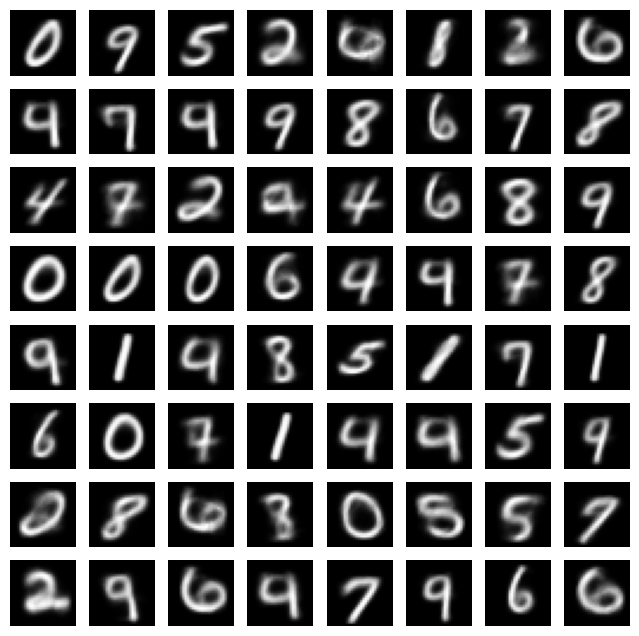

In [16]:
import matplotlib.pyplot as plt
z = torch.randn(64, latent_dim).to(device)
samples = model.decode(z)
# samples = torch.sigmoid(samples)

# print first sample
# print(samples[0])

# Plot the generated images
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
        ax[i, j].axis('off')

# plt.show()
plt.savefig('vae_mnist.webp')

In [17]:
# encode and plot the z values for the train set 
model.eval()
z_all = []
y_all = []
with torch.no_grad():
    for data, target in tqdm(train_loader, desc='Encoding'):
        data = data.to(device)
        output = model(data, compute_loss=False)
        z_all.append(output.z_sample.cpu().numpy())
        y_all.append(target.numpy())

Encoding: 100%|██████████| 469/469 [00:15<00:00, 30.40it/s]


In [18]:
import numpy as np
z_all = np.concatenate(z_all, axis=0)
y_all = np.concatenate(y_all, axis=0)

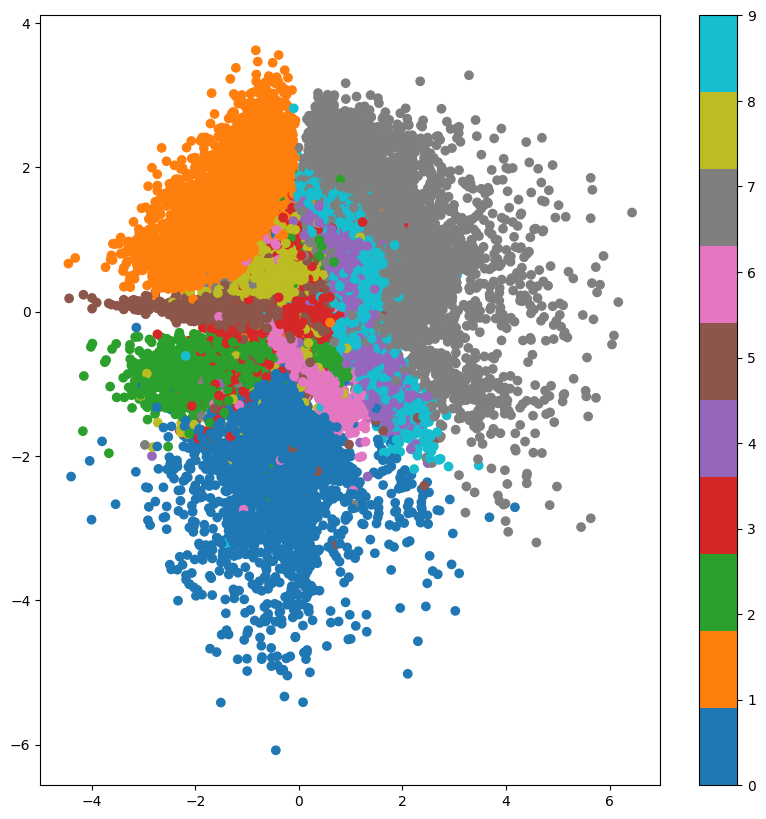

In [19]:
plt.figure(figsize=(10, 10))
plt.scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10')
plt.colorbar()
# plt.show()
plt.savefig('vae_mnist_2d_scatter.webp')

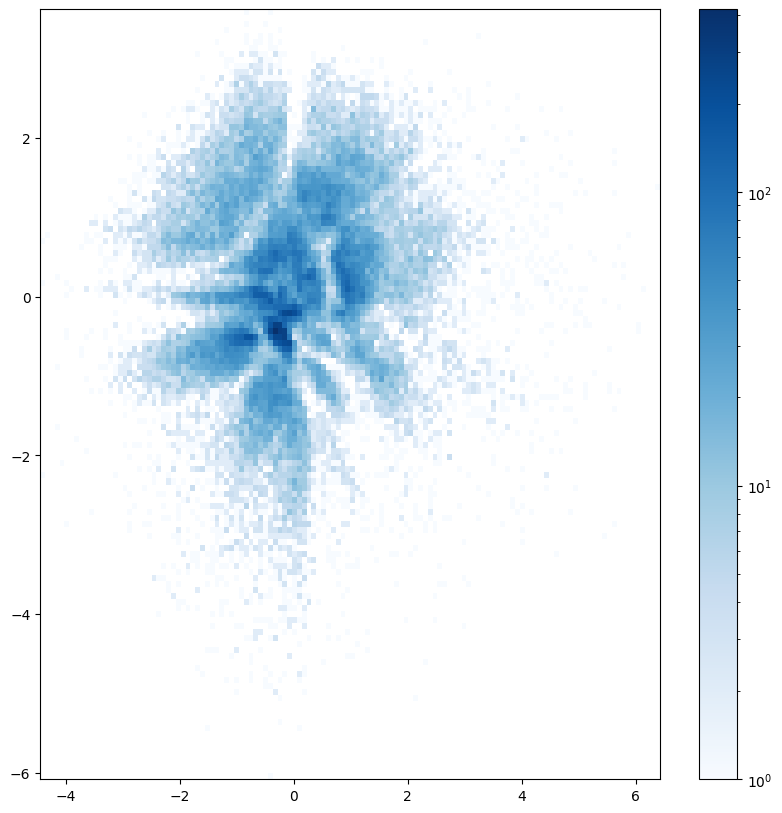

In [20]:
# plot as 2d histogram, log scale
from matplotlib.colors import LogNorm
plt.figure(figsize=(10, 10))
plt.hist2d(z_all[:, 0], z_all[:, 1], bins=128, cmap='Blues', norm=LogNorm())
plt.colorbar()
# plt.show()
plt.savefig('vae_mnist_2d_hist.webp')

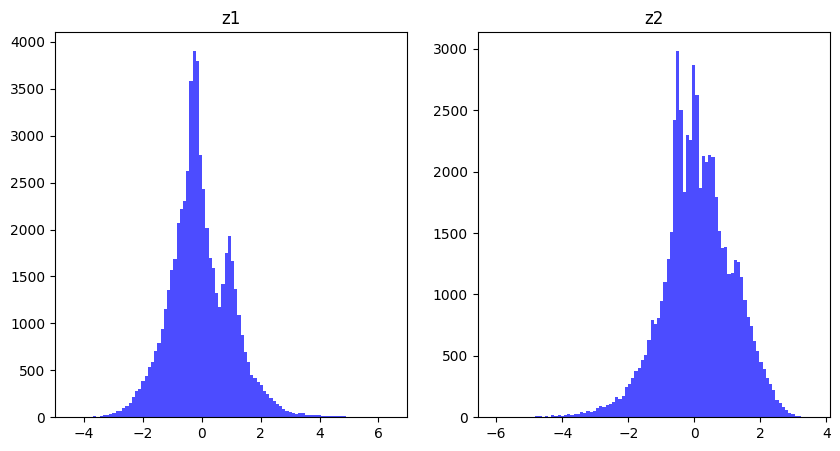

In [21]:
# plot 1d histograms
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(z_all[:, 0], bins=100, color='b', alpha=0.7)
ax[0].set_title('z1')
ax[1].hist(z_all[:, 1], bins=100, color='b', alpha=0.7)
ax[1].set_title('z2')
# plt.show()
plt.savefig('vae_mnist_1d_hist.webp')

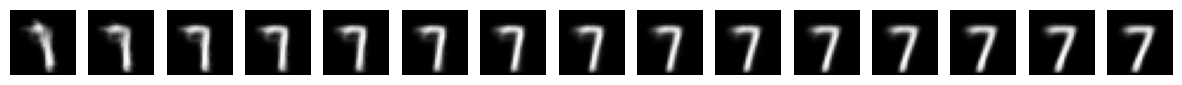

In [45]:
n = 15
z1 = torch.linspace(-0, 1, n)
z2 = torch.zeros_like(z1) + 2
z = torch.stack([z1, z2], dim=-1).to(device)
samples = model.decode(z)
samples = torch.sigmoid(samples)

# Plot the generated images
fig, ax = plt.subplots(1, n, figsize=(n, 1))
for i in range(n):
    ax[i].imshow(samples[i].view(28, 28).cpu().detach().numpy(), cmap='gray')
    ax[i].axis('off')
    
plt.savefig('vae_mnist_interp.webp')

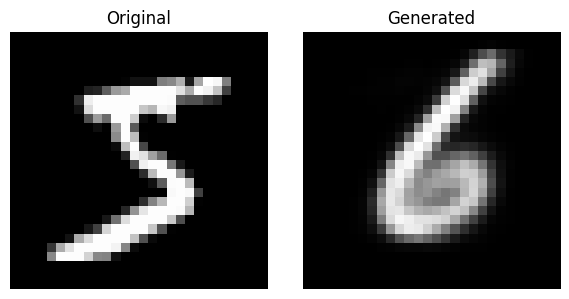

In [47]:
# Take a single record from the dataset
sample_img, sample_label = train_data[0]
sample_img = sample_img.to(device).view(1, -1)

# 1. Encode: get z distribution and sample z
model.eval()
with torch.no_grad():
    encoded = model(sample_img, compute_loss=False)
    z_encoded = encoded.z_sample  # shape: [1, latent_dim]

# 2. Perturb z (e.g., add small noise)
z_new = z_encoded + torch.randn_like(z_encoded) * 0.5

# 3. Decode z to generate a new result
with torch.no_grad():
    decoded = model.decode(z_new)
    decoded_img = decoded.view(28, 28).cpu().numpy()

# Plot original and generated images
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(sample_img.view(28, 28).cpu().numpy(), cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Generated")
plt.imshow(decoded_img, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

## Important Note: VAE Limitations

**VAE cannot generate specific digits on demand!** 

Unlike supervised models, a VAE is a generative model that learns to map between:
- Input space (images) ↔ Latent space (continuous representations)

Key limitations:
1. **No class conditioning**: The VAE doesn't know which digit corresponds to which latent code
2. **Continuous latent space**: There's no discrete mapping like "use z=[1,0] for digit 5"
3. **Probabilistic generation**: Sampling from the latent space generates random digits, not specific ones

This means:
- ✅ You can encode an image of "5" and get a latent representation
- ✅ You can decode a latent vector and get some digit (could be any 0-9)
- ❌ You cannot tell the VAE "generate a 5" and expect it to produce a 5

The next notebook demonstrates this limitation clearly!